# ***GAN***

This notebook can train a GAN using either DCGAN or WGAN. You can: 

1.   Train
2.   Save model in Drive
3.   Generate fashion mnist pictures

To do so, run all (Ctrl+F9). 

You will be asked to connect to the drive and later the script will ask you what to do using inputs. (type?, train?, save?, generate?)



###**Mount drive**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

work_DIR = "/content/drive/My Drive/Deep Learning Course/ex3_301558086_305143315/GAN_question_4"
from os import chdir
chdir(work_DIR)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


###**Imports & run props**

In [2]:
from os import path, mkdir
import numpy as np
import gzip
from keras.optimizers import Adam, RMSprop
from keras.layers import Input, Conv2D, Conv2DTranspose, Flatten, Dense, ReLU, LeakyReLU, BatchNormalization, Reshape, ZeroPadding2D, AveragePooling2D, MaxPooling2D, Activation, Dropout
from keras.initializers import RandomNormal
import keras.backend as K
!pip install h5py
import sys
import random
import matplotlib.pyplot as plt
from google.colab import auth
from googleapiclient.http import MediaFileUpload
from googleapiclient.discovery import build
import argparse
import os
import numpy as np
from keras.models import Model, Sequential
from keras.layers.merge import _Merge
from keras.layers.convolutional import Convolution2D, Conv2DTranspose, UpSampling2D, Conv2D
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import Adam, RMSprop
from keras.datasets import fashion_mnist as mnist
from functools import partial

try:
    from PIL import Image
except ImportError:
    print('This script depends on pillow! Please install it (e.g. with pip install pillow)')
    exit()
    
yes = {'yes','y', 'ye','Yes', ''}

no = {'no','n','No'}

Using TensorFlow backend.


In [3]:
NUMepochs = 15000
GANtype = 'DC' # DC or WGAN
batch_size = 32 
Training_ratio = 5
GRADIENT_PENALTY_WEIGHT = 10 
arch = 'orig'

choiceType = input("do you want to use DC or WGAN? (DC/WGAN)")
if choiceType == "DC":
  GANtype = 'DC'
else:
  GANypte = 'WGAN'

do you want to use DC or WGAN? (DC/WGAN)DC


###**Helper functions**

In [0]:
def f_mnist_voc(ind):
    f_mnist_dict = {0: 'T-shirt/top',
                    1: 'Trouser', 
                    2: 'Pullover',
                    3: 'Dress',
                    4: 'Coat',
                    5: 'Sandal',
                    6: 'Shirt',
                    7: 'Sneaker', 
                    8: 'Bag', 
                    9: 'Ankle boot'}
    if type(ind) == int and ind in f_mnist_dict.keys():
        return f_mnist_dict[ind]
    elif type(ind) == str and ind in f_mnist_dict.values():
        return list(f_mnist_dict.values()).index(ind)
    else:
        raise("bad vocabulary value")

class RandomWeightedAverage(_Merge):
    """Provides a (random) weighted average between real and generated image samples"""
    def _merge_function(self, inputs):
        alpha = K.random_uniform((batch_size, 1, 1, 1))
        return (alpha * inputs[0]) + ((1 - alpha) * inputs[1])
      
def load_data(data_dir, kind='train'):
    labels_path = path.join(data_dir, '%s-labels-idx1-ubyte.gz' % kind)
    images_path = path.join(data_dir, '%s-images-idx3-ubyte.gz' % kind)

    with gzip.open(labels_path, 'rb') as lbpath:
        labels = np.frombuffer(lbpath.read(), dtype=np.uint8, offset=8)

    with gzip.open(images_path, 'rb') as imgpath:
        images = np.frombuffer(imgpath.read(), dtype=np.uint8, offset=16).reshape(len(labels), 28, 28, 1)

    # zero pad images for them to be in size 32x32
    images = np.pad(images, ((0, 0), (2, 2), (2, 2), (0, 0)), 'constant')

    # Rescale -1 to 1
    images = (images.astype(np.float32) - 127.5) / 127.5
    images = np.expand_dims(images, axis=3)

    return images, labels
  
def plot_loss(critic_loss,generator_loss,epochs):
    x = range(0, epochs)
    plt.plot(x,critic_loss)
    plt.plot(x,generator_loss)
    plt.title(GANtype +' losses')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['Critic', 'Generator'], loc='upper right')  
    plt.show()
    
def wasserstein_loss(y_true, y_pred):
    return K.mean(y_true * y_pred)

def save_file_to_drive(name, path):
    auth.authenticate_user()
    drive_service = build('drive', 'v3')

    file_metadata = {'name': name, 'mimeType': 'application/octet-stream'}
    media = MediaFileUpload(path, mimetype='application/octet-stream', resumable=True)
    created = drive_service.files().create(body=file_metadata, media_body=media, fields='id').execute()
    return created

###** DC Model **

In [0]:
class DCGAN:
    def __init__(self, gan_type='DC', lr=0.0002, beta_1=0.5, decay=8e-8, filter=128, kernel=(3, 3), work_DIR = work_DIR, summary = False):
        self.type = gan_type
        self.summary = summary
        if self.summary:
          print("Starting training DCGAN")
        if self.type == 'DC':
          ganloss = 'binary_crossentropy'
        if self.type == "WGAN":
          ganloss = wasserstein_loss
        self.weight_init = RandomNormal(mean=0., stddev=0.02)  
        self.work_DIR = work_DIR
        self.gen_disc_train_ratio = 2
        self.img_shape = (32, 32, 1)
        self.out_shape = (1, 1, 100)
        self.filt_size = filter
        self.kernel = kernel
        self.optimizer = Adam(lr=lr, beta_1=beta_1, decay=decay)                     
        self.G = self.__generator()
        self.G.compile(loss=ganloss, optimizer=self.optimizer)
        self.D = self.__discriminator()
        self.D.compile(loss=ganloss, optimizer=self.optimizer, metrics=['accuracy'])
        self.stacked_generator_discriminator = self.__stacked_generator_discriminator()
        self.D.trainable=False
        self.stacked_generator_discriminator.compile(loss=ganloss, optimizer=self.optimizer)
        self.D.trainable=True
        
        
    def __generator(self):
        
        model = Sequential()
        
        
        model.add(Conv2DTranspose(self.filt_size, kernel_size=self.kernel, strides=4, padding='same', input_shape=self.out_shape))
        model.add(ReLU())
        model.add(BatchNormalization(momentum=0.8))

        
        model.add(Conv2DTranspose(self.filt_size, kernel_size=self.kernel, strides=2, padding='same'))
        model.add(ReLU())
        model.add(BatchNormalization(momentum=0.8))

        
        model.add(Conv2DTranspose(self.filt_size, kernel_size=self.kernel, strides=2, padding='same'))
        model.add(ReLU())
        model.add(BatchNormalization(momentum=0.8))

        
        model.add(Conv2DTranspose(1, kernel_size=self.kernel, strides=2, padding='same', activation='tanh'))
        model.add(Reshape((self.img_shape[0], self.img_shape[1], self.img_shape[2])))
        
        if self.summary:
        
          print("Generator:")
          model.summary() 
        return model

    def __discriminator(self):
      

        model = Sequential()
        
        # Residual block #1
        model.add(Conv2D(self.filt_size, kernel_size=(3, 3), strides=2, padding='same', input_shape=self.img_shape, kernel_initializer=self.weight_init))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.4))
        
        # Residual block #2
        model.add(Conv2D(self.filt_size, kernel_size=(3, 3), strides=2, padding='same',kernel_initializer=self.weight_init))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.4))
        
        # Residual block #3
        model.add(Conv2D(self.filt_size, kernel_size=(3, 3), padding='same',kernel_initializer=self.weight_init))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.4))
  
        # Residual block #4
        model.add(Conv2D(self.filt_size, kernel_size=(3, 3), padding='same',kernel_initializer=self.weight_init))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.4))
        
        # Relu + mean pooling
        model.add(AveragePooling2D(pool_size=(2, 2)))
        model.add(ReLU())
    
        # Linear:
        model.add(Flatten())
        model.add(Dense(1, use_bias=False, activation='sigmoid'))
        if self.summary:
          print("Discriminator:")
          model.summary()
        return model

    def __stacked_generator_discriminator(self):

        self.D.trainable = False

        model = Sequential()
        model.add(self.G)
        model.add(self.D)

        return model

    def wasserstein_loss(self, y_true, y_pred):
        return K.mean(y_true * y_pred)

    def plot_images(self, save2file=False, samples=16, step=0):

        filename = "./gen_imgs/" +self.type +"/images_for_epoch_{}.png".format(step)
        noise = np.random.normal(0, 1, (samples,) + self.out_shape)

        images = self.G.predict(noise)

        plt.figure(figsize=(10, 10))

        for i in range(images.shape[0]):
            plt.subplot(4, 4, i+1)
            image = images[i, :, :, :]
            image = np.reshape(image, [self.img_shape[0], self.img_shape[1]])
            plt.imshow(image, cmap='gray')
            plt.axis('off')
        plt.tight_layout()

        if save2file:
            plt.savefig(filename)
            plt.close('all')
        else:
            plt.show()
            
    def SaveModel(self, path):
        self.G.save(path) #self.work_DIR+"/GeneratorModel_type_"+self.type+".h5"
      
    def plot_graphs(self, graph_arr):
        epochs_arr = np.arange(graph_arr.shape[0])
        plt.plot(epochs_arr, graph_arr[:, 0], epochs_arr, graph_arr[:, 1])
        plt.title(GANtype +' losses')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(('Discriminator loss', 'Generator loss'), loc='upper right')
        plt.show()

        
    def train(self, x_train, epochs=20000, batch=64, print_interval=50, save_interval=50):
        print("Start training session with {} epochs and batch size of {}".format(epochs, batch))
        print("Saving images every {} epochs".format(save_interval))
        
        graph_loss_array = np.zeros((epochs, 2))
        
        for epo in range(epochs):

            # train discriminator
            random_index = np.random.randint(0, len(x_train) - batch // self.gen_disc_train_ratio)
            legit_images = x_train[random_index: random_index + batch // self.gen_disc_train_ratio].reshape(batch // self.gen_disc_train_ratio, self.img_shape[0],
                                                                            self.img_shape[1], self.img_shape[2])

            gen_noise = np.random.normal(0, 1, (batch//self.gen_disc_train_ratio,)+ self.out_shape)
            syntetic_images = self.G.predict(gen_noise)

            x_combined_batch = np.concatenate((legit_images, syntetic_images))
            y_combined_batch = np.concatenate((np.ones((batch//self.gen_disc_train_ratio, 1)), np.zeros((batch//self.gen_disc_train_ratio, 1))))
            
            d_loss = self.D.train_on_batch(x_combined_batch, y_combined_batch)
          
            # train generator
            noise = np.random.normal(0, 1, (batch,) + self.out_shape)
            y_mislabled = np.ones((batch, 1))
            
            self.D.trainable = False
            g_loss = self.stacked_generator_discriminator.train_on_batch(noise, y_mislabled)
          
            self.D.trainable = True
          
            # save values for loss graph
            graph_loss_array[epo, :] = [d_loss[0], g_loss]
          
            # print status & save images
            if epo % print_interval == 0:
                print('epoch: {}, [Discriminator :: loss: {}], [ Generator :: loss: {}]'.format(epo, d_loss[0], g_loss))
            if epo % save_interval == 0:
                self.plot_images(save2file=True, step=epo)
                
        self.plot_graphs(graph_loss_array)

###*WGAN*

In [0]:
class WGANGP:
    def __init__(self, gan_type='WGAN', lr=0.0002, beta_1=0.5, decay=8e-8, filter=128, kernel=(3, 3), work_DIR = work_DIR, summary= False):
        self.img_rows = 28
        self.type = gan_type
        self.summary = summary
        if self.summary:
          print("Starting training WGAN")
        self.img_cols = 28
        self.channels = 1
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = 100
        self.out_shape = (1, 1, 100)
        
        # Following parameter and optimizer set as recommended in paper
        self.n_critic = 5
        if arch == "orig":
          optimizer = Adam(lr=0.0001, beta_1=0, beta_2=0.9, epsilon=None, decay=0.0, amsgrad=False)
          #optimizer = RMSprop(lr=0.00005)
        else:
          optimizer = Adam(lr=0.0001, beta_1=0, beta_2=0.9, epsilon=None, decay=0.0, amsgrad=False)
        # Build the generator and critic
        self.generator = self.build_generator()
        self.critic = self.build_critic()

        #-------------------------------
        # Construct Computational Graph
        #       for the Critic
        #-------------------------------

        # Freeze generator's layers while training critic
        self.generator.trainable = False

        # Image input (real sample)
        real_img = Input(shape=self.img_shape)

        # Noise input
        z_disc = Input(shape=(self.latent_dim,))
        # Generate image based of noise (fake sample)
        fake_img = self.generator(z_disc)

        # Discriminator determines validity of the real and fake images
        fake = self.critic(fake_img)
        valid = self.critic(real_img)

        # Construct weighted average between real and fake images
        interpolated_img = RandomWeightedAverage()([real_img, fake_img])
        # Determine validity of weighted sample
        validity_interpolated = self.critic(interpolated_img)

        # Use Python partial to provide loss function with additional
        # 'averaged_samples' argument
        partial_gp_loss = partial(self.gradient_penalty_loss,
                          averaged_samples=interpolated_img)
        partial_gp_loss.__name__ = 'gradient_penalty' # Keras requires function names

        self.critic_model = Model(inputs=[real_img, z_disc],
                            outputs=[valid, fake, validity_interpolated])
        self.critic_model.compile(loss=[self.wasserstein_loss,
                                              self.wasserstein_loss,
                                              partial_gp_loss],
                                        optimizer=optimizer,
                                        loss_weights=[1, 1, 10])
        #-------------------------------
        # Construct Computational Graph
        #         for Generator
        #-------------------------------

        # For the generator we freeze the critic's layers
        self.critic.trainable = False
        self.generator.trainable = True

        # Sampled noise for input to generator
        z_gen = Input(shape=(100,))
        # Generate images based of noise
        img = self.generator(z_gen)
        # Discriminator determines validity
        valid = self.critic(img)
        # Defines generator model
        self.generator_model = Model(z_gen, valid)
        self.generator_model.compile(loss=self.wasserstein_loss, optimizer=optimizer)


    def gradient_penalty_loss(self, y_true, y_pred, averaged_samples):
        """
        Computes gradient penalty based on prediction and weighted real / fake samples
        """
        gradients = K.gradients(y_pred, averaged_samples)[0]
        # compute the euclidean norm by squaring ...
        gradients_sqr = K.square(gradients)
        #   ... summing over the rows ...
        gradients_sqr_sum = K.sum(gradients_sqr,
                                  axis=np.arange(1, len(gradients_sqr.shape)))
        #   ... and sqrt
        gradient_l2_norm = K.sqrt(gradients_sqr_sum)
        # compute lambda * (1 - ||grad||)^2 still for each single sample
        gradient_penalty = K.square(1 - gradient_l2_norm)
        # return the mean as loss over all the batch samples
        return K.mean(gradient_penalty)


    def wasserstein_loss(self, y_true, y_pred):
        return K.mean(y_true * y_pred)

    def build_generator(self):
      
        if arch == "orig": #works great
          
          model = Sequential()

          model.add(Dense(128 * 7 * 7, activation="relu", input_dim=self.latent_dim))
          model.add(Reshape((7, 7, 128)))        
          model.add(UpSampling2D())
          
          model.add(Conv2D(128, kernel_size=3, padding="same"))
          model.add(BatchNormalization(momentum=0.8))
          model.add(Activation("relu"))
          model.add(UpSampling2D())
          
          model.add(Conv2D(128, kernel_size=3, padding="same"))
          model.add(BatchNormalization(momentum=0.8))
          model.add(Activation("relu"))
          
          model.add(Conv2D(128, kernel_size=3, padding="same"))
          model.add(BatchNormalization(momentum=0.8))
          model.add(Activation("relu"))
          
          model.add(Conv2D(1, kernel_size=3, padding="same"))
          model.add(Activation("tanh"))
          if self.summary:
            print("Generator:")
            model.summary()
          
        if arch == "BIG":
          
          model = Sequential()
          #TODO: check strides, axis in BN?
          model.add(Dense(128 * 4 * 4, activation="relu", input_dim=self.latent_dim))
          model.add(Reshape((4, 4, 128)))
          model.add(UpSampling2D())
          
          # Residual block #1
          model.add(Conv2DTranspose(128, kernel_size=(3, 3), strides=4, padding='same'))
          model.add(ReLU())
          model.add(BatchNormalization(momentum=0.8))
          model.add(Conv2DTranspose(128, kernel_size=(3, 3), strides=4, padding='same'))
          model.add(ReLU())
          model.add(BatchNormalization(momentum=0.8))

          # Residual block #2
          model.add(Conv2DTranspose(128, kernel_size=(3, 3), strides=2, padding='same'))
          model.add(ReLU())
          model.add(BatchNormalization(momentum=0.8))
          model.add(Conv2DTranspose(128, kernel_size=(3, 3), strides=2, padding='same'))
          model.add(ReLU())
          model.add(BatchNormalization(momentum=0.8))

          # Residual block #3
          model.add(Conv2DTranspose(128, kernel_size=(3, 3), strides=2, padding='same'))
          model.add(ReLU())
          model.add(BatchNormalization(momentum=0.8))
          model.add(Conv2DTranspose(128, kernel_size=self.kernel, strides=2, padding='same'))
          model.add(ReLU())
          model.add(BatchNormalization(momentum=0.8))

           # conv + tanh
          model.add(Conv2DTranspose(1, kernel_size=self.kernel, strides=2, padding='same', activation='tanh'))
    
          model.add(Reshape((self.img_shape[0], self.img_shape[1], self.img_shape[2])))

          return model
          
        noise = Input(shape=(self.latent_dim,))
        img = model(noise)

        return Model(noise, img)

    def build_critic(self):
        if arch == "orig": 
          
          
          model = Sequential()

          model.add(Conv2D(128, kernel_size=3, strides=2, input_shape=self.img_shape, padding="same"))
          model.add(LeakyReLU(alpha=0.2))
          model.add(Dropout(0.25))
          
          model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
          model.add(ZeroPadding2D(padding=((0,1),(0,1))))
          
          model.add(LeakyReLU(alpha=0.2))
          model.add(Dropout(0.25))
          
          model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
        
          model.add(LeakyReLU(alpha=0.2))
          model.add(Dropout(0.25))
          
          model.add(Conv2D(128, kernel_size=3, strides=1, padding="same"))
         
          model.add(LeakyReLU(alpha=0.2))
          model.add(Dropout(0.25))
          
          model.add(Flatten())
          model.add(Dense(1))
          if self.summary:
            print("Critic")
            model.summary()
            
        if arch == "BIG":
          
          # not yet residual
          model = Sequential()
          
            # Residual block #1
          model.add(Conv2D(128, (3, 3),padding='same',input_shape=self.img_shape, kernel_initializer=self.weight_init))
          model.add(LeakyReLU(alpha=0.2))
          
          model.add(Conv2D(128, (3, 3), padding='same',kernel_initializer=self.weight_init))
          model.add(LeakyReLU(alpha=0.2))
          model.add(AveragePooling2D(pool_size=(2, 2)))
          
          # Residual block #2
          model.add(Conv2D(128, (3, 3), padding='same',kernel_initializer=self.weight_init))
          model.add(LeakyReLU(alpha=0.2))
          
          model.add(Conv2D(128, (3, 3), padding='same',kernel_initializer=self.weight_init))
          model.add(LeakyReLU(alpha=0.2))
          model.add(AveragePooling2D(pool_size=(2, 2)))

        
          # Residual block #3
          model.add(Conv2D(128, (3, 3), padding='same',kernel_initializer=self.weight_init))
          model.add(LeakyReLU(alpha=0.2))
          model.add(Conv2D(128, (3, 3), padding='same',kernel_initializer=self.weight_init))
          model.add(LeakyReLU(alpha=0.2))
  
          # Residual block #4
          model.add(Conv2D(128, (3, 3), padding='same',kernel_initializer=self.weight_init))
          model.add(LeakyReLU(alpha=0.2))
          model.add(Conv2D(128, (3, 3), padding='same',kernel_initializer=self.weight_init))
          model.add(LeakyReLU(alpha=0.2))
          # Relu + mean pooling
          model.add(ReLU())
          model.add(AveragePooling2D(pool_size=(8, 8)))
        
          # Linear:
          model.add(Flatten())
          model.add(Dense(1, use_bias=False, activation='sigmoid'))

        return model
          
          
        img = Input(shape=self.img_shape)
        validity = model(img)

        return Model(img, validity)
      
    def SaveModel(self, path):
        self.generator.save(path) #self.work_DIR+"/GeneratorModel_type_"+self.type+".h5"
        
    def plot_images(self, save2file = False, epoch = 0):
        
        r, c = 5, 5
        noise = np.random.normal(0, 1, (r * c, self.latent_dim))
        gen_imgs = self.generator.predict(noise)

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 1

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
                axs[i,j].axis('off')
                cnt += 1
        filename = "./gen_imgs/" +self.type +"/images_for_epoch_{}.png".format(epoch)
        
        if save2file:
            os.makedirs(os.path.dirname(filename), exist_ok=True)
            plt.savefig(filename)
            plt.close('all')
        else:
            plt.show()
            
    def train(self, epochs, batch_size, print_interval=200):
      
        # loss vector for plotting
        CriticLossV = np.zeros(epochs)
        GeneratorLossV = np.zeros(epochs)
        
        # Load the dataset
        (X_train, _), (X_test, _) = mnist.load_data()
        #X_train = np.concatenate((x_train, x_test), axis=0)
        # Rescale -1 to 1
        X_train = (X_train.astype(np.float32) - 127.5) / 127.5
        X_train = np.expand_dims(X_train, axis=3)

        # Adversarial ground truths
        valid = -np.ones((batch_size, 1))
        fake =  np.ones((batch_size, 1))
        dummy = np.zeros((batch_size, 1)) # Dummy gt for gradient penalty
        
        
        for epoch in range(epochs):
            
            for j in range(self.n_critic):

               
                #  Train Discriminator
                

                # Select a random batch of images
                idx = np.random.randint(0, X_train.shape[0], batch_size)
                imgs = X_train[idx]
                # Sample generator input
                noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
                # Train the critic
                d_loss = self.critic_model.train_on_batch([imgs, noise],
                                                                [valid, fake, dummy]) #(training data, traget data)
               
            
            #  Train Generator
            

            g_loss = self.generator_model.train_on_batch(noise, valid) # valid = results of critic on imgs from generator
            
            # fill loss vectors
            
            CriticLossV[epoch-1] = -d_loss[0]
            GeneratorLossV[epoch-1] = -g_loss
            
            # Plot the progress
            if epoch % print_interval == 0:
                print ("%d [D loss: %f] [G loss: %f]" % (epoch, d_loss[0], g_loss))

            # If at save interval => save generated image samples
            if epoch % print_interval == 0:
                self.plot_images(save2file = True, epoch = epoch)
        
        print(len(CriticLossV))
        print(len(GeneratorLossV))
        plot_loss(CriticLossV,GeneratorLossV,epochs)
        print('')
            
    
        


###**Main**

sample from data:


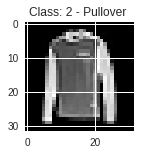


 picked type is DC

Would you like to train a new GAN?  (y/n) y
Starting training DCGAN
Instructions for updating:
Colocations handled automatically by placer.
Generator:
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_transpose_1 (Conv2DTr (None, 4, 4, 128)         115328    
_________________________________________________________________
re_lu_1 (ReLU)               (None, 4, 4, 128)         0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 4, 4, 128)         512       
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 8, 8, 128)         147584    
_________________________________________________________________
re_lu_2 (ReLU)               (None, 8, 8, 128)         0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 

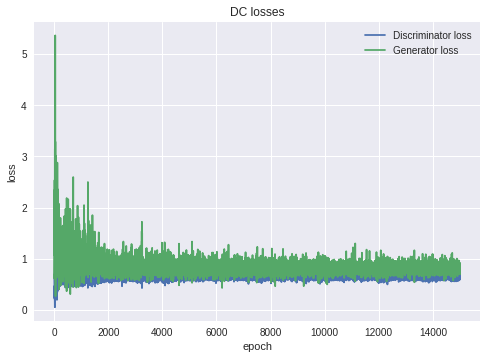

Done


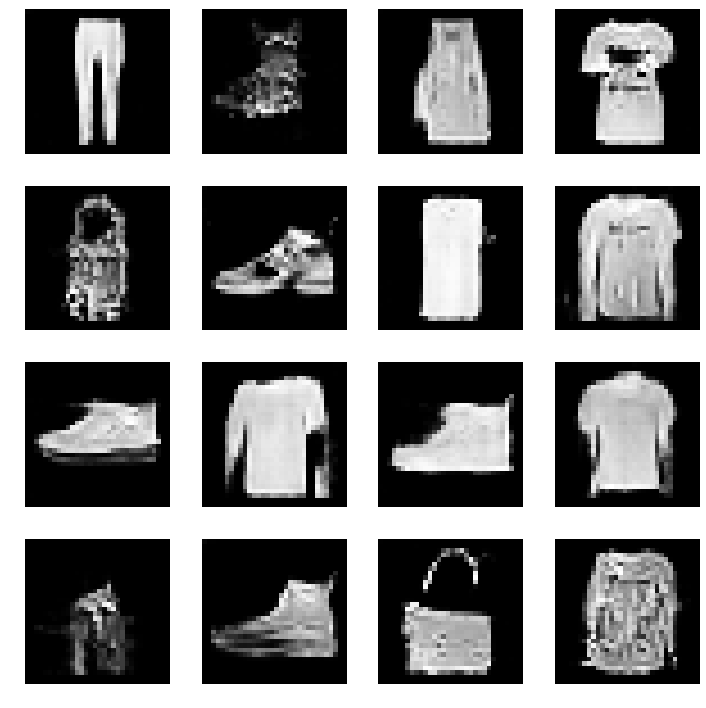

In [8]:

# load data:
x_train, y_train = load_data(work_DIR + "/data", kind='train')
x_test, y_test = load_data(work_DIR + "/data", kind='test')


# show randum image from data:
print("sample from data:")
index = random.randint(0, len(x_train))
image = x_train[index].squeeze()
classint, classname = y_train[index], f_mnist_voc(int(y_train[index]))
plt.figure(figsize=(2, 2))
plt.imshow(image, cmap="gray")
plt.title("Class: {} - {} ".format(classint, classname))
plt.show()
print('\n picked type is ' + GANtype)

# take all images from data, throw the labels
#X_train = np.concatenate((x_train, x_test), axis=0) #needs work to combine for both

was_trained = False

# train
print('')
choice = input('Would you like to train a new GAN?  (y/n) ').lower()
if choice in yes:
    was_trained = True
    
    if GANtype == "DC":
      gan = DCGAN(gan_type = GANtype, summary = True)
      gan.train(x_train, epochs=NUMepochs, batch=64, print_interval=200, save_interval=200)
      
    if GANtype == "WGAN":
      gan = WGANGP(summary = True)
      gan.train(epochs=NUMepochs, batch_size=32, print_interval=200)
      
    print('Done')
    gan.plot_images()  
    
elif choice in no:
    print('noted')
    print('')
else:
    sys.stdout.write("Please respond with 'yes' or 'no' (y/n)")


    



Would you like to generate using the last saved model on Drive? (y/n)y


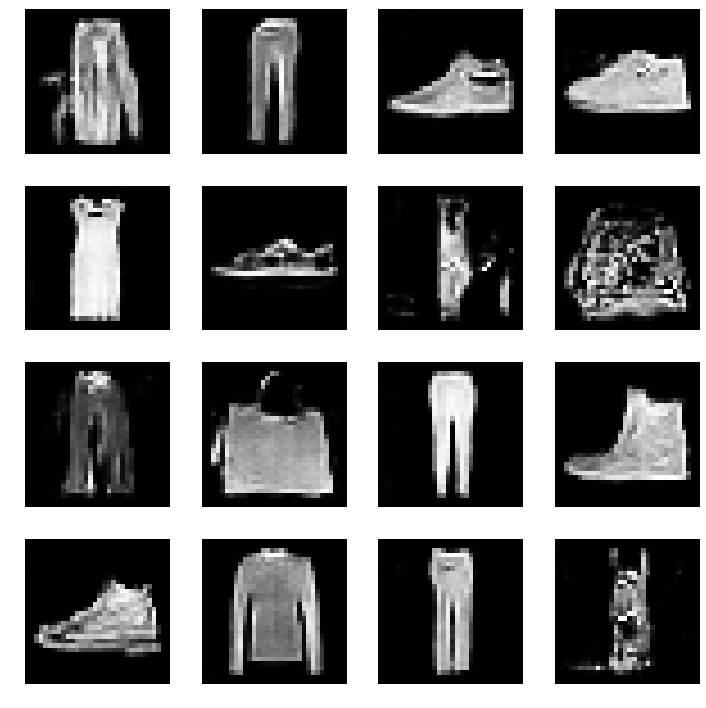

That's all folks


In [0]:
work_DIR_b = work_DIR #"/Deep Learning Course/ex3_301558086_305143315/GAN_question_4/0801"
# save
if was_trained:
    print('')

    choiceS = input('Would you like to save the model to Drive? (y/n)').lower()
    if choiceS in yes:
        save_model = True
    elif choiceS in no:
        save_model = False
    else:
        sys.stdout.write("Please respond with 'yes' or 'no'")

    if save_model:    
        
        auth.authenticate_user()
        fileNameAndPath = work_DIR_b+"/Final_GeneratorModel_type_"+GANtype+".h5"
        gan.SaveModel(fileNameAndPath)
        save_file_to_drive(fileNameAndPath, fileNameAndPath)
        print("Model saved")
        
# generate
print('')

choiceG = input('Would you like to generate using the last saved model on Drive? (y/n)').lower()
if choiceG in yes:
    if GANtype =="DC":
      gan = DCGAN(gan_type = GANtype)
      gan.G.load_weights(work_DIR_b+"/Final_GeneratorModel_type_"+GANtype+".h5")
      gan.plot_images()
    if GANtype == "WGAN":
      gan = WGANGP(gan_type = GANtype)
      gan.generator.load_weights(work_DIR_b+"/Final_GeneratorModel_type_"+GANtype+".h5")
      gan.plot_images()  
    print("That's all folks")
elif choiceG in no:
    print("That's all folks")
else:
    sys.stdout.write("Please respond with 'yes' or 'no'")